In [1]:
import matplotlib.pyplot as plt
import numpy as np
from utils.objects import GenerationClass
from utils.config import color_maps, ycb_heights
import os
from glob import glob
from scipy import sparse
from PIL import Image
import json
from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.utils.sapien_utils import look_at
from mani_skill2.sensors.camera import CameraConfig
from mani_skill2.utils.registration import register_env
from pathlib import Path
import gymnasium as gym
from sapien.core import Pose
import numpy as np
from transforms3d.euler import euler2quat, quat2euler
from utils.config import ycb_heights, color_maps
from glob import glob
from scipy import sparse
from PIL import Image
import json
import os

from IPython.display import clear_output
# save_dir = "../final_data/"
# move_one_dir = os.path.join(save_dir, "move")
# move_cube_dir = os.path.join(move_one_dir, "cube")
# move_ycb_dir = os.path.join(move_one_dir, "ycb")
# os.makedirs(move_one_dir, exist_ok=True)
# os.makedirs(move_cube_dir, exist_ok=True)
# os.makedirs(move_ycb_dir, exist_ok=True)

In [2]:
# model_paths = sorted(glob("../data/mani_skill2_ycb/models/*"), key=lambda x: int(x.split('/')[-1][:3]))
model_paths = sorted(glob("../models/*/mesh.obj"))

gen = GenerationClass(model_paths)

In [3]:
# n = 20
# gen.generate(1, "place_object_in_direction", n)
# gen.generate(3, "place_object_in_direction", n)
# gen.generate(4, "place_object_in_direction", n)

# gen.generate(2, "place_object_on_another", n)
# gen.generate(3, "place_object_on_another", n)
# gen.generate(4, "place_object_on_another", n)

# gen.generate(3, "place_object_in_between", n)

# gen.generate(3, "remove_object", n)

# gen.generate(3, "order_by_color", n)

# gen.generate(2, "move_object", n)

# gen.generate(3, "move_object_toward_another", n)

In [4]:
from utils.run_tsr import process_images
from utils.conver_color import convert
# name = "dog"

# # os.removedirs(f"models/{name}")
# process_images([f"../images/{name}.png"], output_dir=f"models/{name}", foreground_ratio=0.7)
# convert(f"../models/{name}/0/mesh.obj", f"../models/{name}")

/home/mkim/miniconda3/envs/mixlab/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mkim/miniconda3/envs/mixlab/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mkim/miniconda3/envs/mixlab/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
models = sorted(os.listdir("../models"))

In [9]:
def model_data(model):
    return {
        "name": model,
        "scale": 1,
        "static": True,
    }

def model_configs(n):
    """
    n: number of models
    models: list of models
    """
    object_cfgs = [model_data(m) for m in np.random.choice(models, n, replace=False)]
    camera_cfgs = {"p": [-1, 0, 1], "fov": 1.2}

    return object_cfgs, camera_cfgs

for i in range(10):
    object_cfgs, camera_cfgs = model_configs(2)
    env = gen.get_env(object_cfgs, camera_cfgs)
    gen.initialize_positions(2, object_cfgs, )

    break

2024-04-02 17:28:56,534 - mani_skill2 - WARNING - Override registered env CustomEnv-v0
[2024-04-02 17:28:56.535] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
/home/mkim/miniconda3/envs/mixlab/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.cube_half_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.cube_half_size` for environment variables or `env.get_wrapper_attr('cube_half_size')` that will search the reminding wrappers.
  logger.warn(


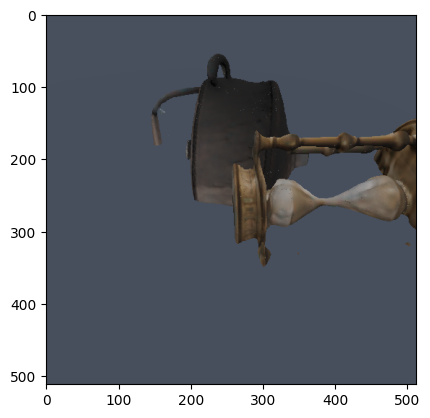

In [11]:
obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
img = obs['image']["base_camera"]["rgb"]

plt.imshow(img)

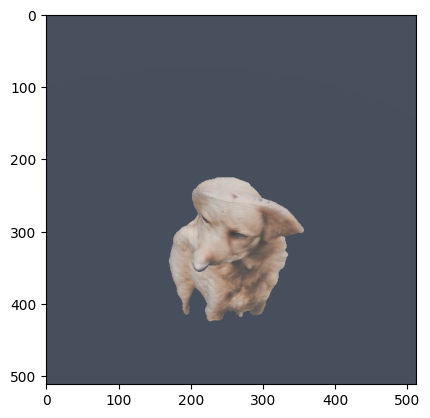

In [39]:
### imported 3d objects

names = [d for d in os.listdir("../models") if d != 'imgs']
name = names[-2]
name = "dog"
# for name in names:
@register_env("CustomEnv-v0", max_episode_steps=200, override=True)
class CustomEnv(PickCubeEnv):
    def _load_actors(self):
        self._add_ground(render=self.bg_name is None)
        builder = self._scene.create_actor_builder()
        filepath = f"/home/mkim/Nserver/mix-lab/maniskill2_dev/models/{name}/mesh.obj"
        scale = 0.5
        scale *= self.cube_half_size / 0.01887479572529618
        builder.add_multiple_collisions_from_file(
            filename=filepath, scale=scale, density=1000
        )
        builder.add_visual_from_file(filename=filepath, scale=scale)
        self.obj = builder.build(name=name)
        self.goal_site = self._build_sphere_site(self.goal_thresh)

    def _register_cameras(self):
        pose = look_at([-1, 0, 1], [0, 0, 0])
        return CameraConfig(
            "base_camera", pose.p, pose.q, 512, 512, 1.2, 0.01, 10
        )

env = gym.make("CustomEnv-v0", obs_mode="rgbd", camera_cfgs={"add_segmentation": True})
obs, _ =env.reset()


env.unwrapped.get_articulations()[0].set_pose(Pose([0, 0, 10], [1, 0, 0, 0]))
# quat = euler2quat(np.random.uniform(-np.pi*2, np.pi*2), np.random.uniform(-np.pi*2, np.pi*2), np.random.uniform(-np.pi*2, np.pi*2))
quat = euler2quat(np.pi/2, 0, np.random.uniform(np.pi*3/4, np.pi*5/4))#np.random.uniform(-np.pi*2, np.pi*2))
env.obj.set_pose(Pose([-0.5, 0, 0.3], quat))
# for i in range(10):
obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))

img = obs['image']["base_camera"]["rgb"]
mask = obs['image']["base_camera"]["Segmentation"][..., :3].copy()
mask[mask != env.obj.id-2] = 0
mask = np.amax(mask.astype(bool), axis=2)

img[mask] += 50
# img[mask] += 25
img = np.clip(img, 0, 255)

clear_output(wait=True)
plt.imshow(img)
# plt.savefig(f'../models/imgs/{name}')
plt.show()

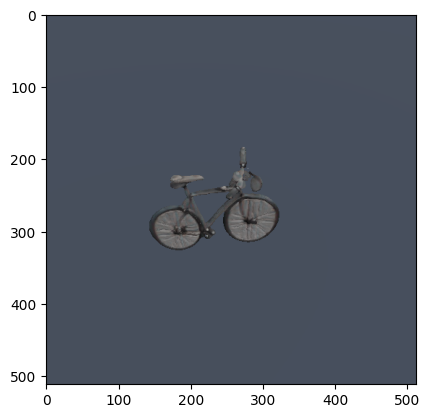

In [25]:
env.obj.lock_motion(False, False, False, True, True, True)
env.obj.set_pose(Pose([-0.24018, 0.047002, 0.206021], [-0.219104, -0.219104, 0.672305, 0.672305]))

for i in range(10):
    clear_output(wait=True)
#     env.obj.add_force_at_point( np.array([1000, 0, 0]) * 4, np.array([0, 0, 0]))

    obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
    img = obs['image']["base_camera"]["rgb"]
    plt.imshow(img)
    plt.show()
